# Data Analysis

**Purpose:**
Performing the following data analysis:
1. temporal distribution of different categories: food, shop, night life, travel)
2. poi choice affected by nearby pois

**Input file:** 
1. Model input data: './np_save/sample_sets.npy'
2. POI_cat_distrib : './np_save/poi_cat_distrib.npy'
3. POI distance matrix: './np_save/dist_mat.npy'
4. Maximum distance and sequence length: './np_save/max_dist.npy', './np_save/max_seq_len.npy'

**Output file:** 
tbd

**Creation Date:** 9th Nov 2019

In [1]:
# denpendencies

import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt

import Helper_Functions as Helper

In [2]:
# import related files

data = pd.read_csv('./data_CAL.csv')

dir = './np_save_CAL/'

samples = Helper.load_dict(dir + 'sample_sets.pkl')
POI_cat_distrib = Helper.load_dict(dir + 'poi_cat_distrib.pkl')
dist_mat = np.load(dir + 'dist_mat.npy', allow_pickle=True)

POI_reIndex_mapping = np.load(dir + 'POI_reIndex_mapping.npy', allow_pickle=True)
user_reIndex_mapping = np.load(dir + 'user_reIndex_mapping.npy', allow_pickle=True)
cat_reIndex_mapping = np.load(dir + 'cat_reIndex_mapping.npy', allow_pickle=True)

max_dist = np.load(dir + 'max_dist.npy', allow_pickle=True)
max_seq_len = np.load(dir + 'max_seq_len.npy', allow_pickle=True)
neg_num = np.load(dir + 'neg_sample_num.npy', allow_pickle=True)

## Temporal distribution of different categories

## POI choice affected by nearby POIs

In [3]:
# transform dist_mat to display full dist b/w each pair of pois

new_dist_mat = np.transpose(dist_mat)
num_rows, num_cols = len(new_dist_mat), len(new_dist_mat)

for i in range(num_rows):
    for j in range(i, num_cols):
        new_dist_mat[j][i] = new_dist_mat[i][j]
        
new_dist_mat

array([[ 0.        ,  1.75432238, 16.3255705 , ..., 17.25471738,
        10.82419259,  8.78870258],
       [ 1.75432238,  0.        , 14.69529891, ..., 16.11986614,
        12.46412498,  7.80256105],
       [16.3255705 , 14.69529891,  0.        , ...,  7.86961172,
        27.1462321 ,  9.81268287],
       ...,
       [17.25471738, 16.11986614,  7.86961172, ...,  0.        ,
        27.44678227,  8.49913289],
       [10.82419259, 12.46412498, 27.1462321 , ..., 27.44678227,
         0.        , 19.01498426],
       [ 8.78870258,  7.80256105,  9.81268287, ...,  8.49913289,
        19.01498426,  0.        ]])

In [4]:
def valid_poi_ratio(dist_range, samples):

    total_poi = 0 # poi within designated distance b/w destination & contains same category as true destination
    valid_poi = 0 # poi with less amount of stores for the same category compared to true destination

    for user in samples.keys():
        user_samples = samples[user]
        for visit in user_samples:
            dest = visit[0][-1]
            dest_cat = visit[4][-1]
            dest_cat_storeNo = 1 # default: individual poi
            if dest in POI_cat_distrib.keys(): # collective poi
                dest_cat_storeNo = POI_cat_distrib[dest][dest_cat]

            candidate_dest_list = [x for x in range(len(dist_mat)) if new_dist_mat[dest][x] < dist_range and x!=dest]

            for candidate in candidate_dest_list:
                if candidate in POI_cat_distrib.keys(): # collective poi
                    if dest_cat in POI_cat_distrib[candidate].keys(): # and contains target category
                        total_poi += 1
                        if POI_cat_distrib[candidate][dest_cat] < dest_cat_storeNo: # and whose category store less than dest
                            valid_poi += 1
                else: # individual poi
                    old_poi_id = POI_reIndex_mapping[candidate]
                    try:
                        cat_id = np.where(cat_reIndex_mapping == data[data['POI_id']==old_poi_id].iloc[0]['L2_id'])[0][0]
                    except IndexError: # indidual poi's cat not in valid sequence
                        continue
                    if cat_id == dest_cat: # poi of the same category
                        total_poi += 1
                        valid_poi += 1

    return valid_poi / total_poi      

In [5]:
valid_ratio_list = []

dist_range_list = np.arange(0.1, 2.1, step=0.1)

for dist_range in dist_range_list:
    
    print(dist_range)
    
    valid_ratio_list.append(valid_poi_ratio(dist_range, samples))    
    
valid_ratio_list

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0


[0.9166666666666666,
 0.9047619047619048,
 0.9354838709677419,
 0.9245283018867925,
 0.9104477611940298,
 0.8987341772151899,
 0.9183673469387755,
 0.9349593495934959,
 0.9415584415584416,
 0.9344262295081968,
 0.9343434343434344,
 0.9395348837209302,
 0.9449152542372882,
 0.9484126984126984,
 0.9338235294117647,
 0.9366197183098591,
 0.933993399339934,
 0.9341692789968652,
 0.9287833827893175,
 0.9302325581395349]

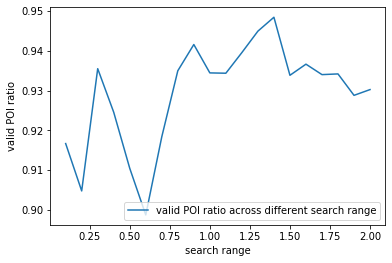

In [6]:
x_range = np.arange(0.1, 2.1, step=0.1)

plt.plot(x_range, valid_ratio_list, label = 'valid POI ratio across different search range')
    
plt.xlabel('search range')
plt.ylabel('valid POI ratio')
plt.legend(loc='lower right')
plt.savefig('./data_analysis/valid_POI_ratio_CAL.png')

plt.show()

np.save('./data_analysis/valid_POI_ratio_CAL.npy', valid_ratio_list)
    
valid_ratio_list_pd = pd.DataFrame(valid_ratio_list, x_range)
    
valid_ratio_list_pd.to_csv('./data_analysis/valid_POI_ratio_CAL.csv')